In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

seed = 100
mapper = JordanWignerMapper()
driver = PySCFDriver(
    atom=f"H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

def create_ansatz(es_problem):
    return UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

def create_vqe_solver(estimator, ansatz):
    vqe_solver = VQE(estimator, ansatz, SPSA())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    return vqe_solver

class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1, t2):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.time_cx = 22
        self.time_swap = 17
        self.single_gate_times = {
            "h": 6,
            "x": 10,
            "y": 10,
            "measure": 10
        }

        self.add_errors()

    def add_errors(self):
        for gate, time in self.single_gate_times.items():
            self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, time), gate)
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_cx).expand(thermal_relaxation_error(self.t1, self.t2, self.time_cx)), "cx")
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_swap).expand(thermal_relaxation_error(self.t1, self.t2, self.time_swap)), "swap")


class EnergyCalculator:
    def __init__(self, acc):
        self.estimator = AerEstimator(
            backend_options={
                "method": "density_matrix",
                "coupling_map": [(0, 1), (1, 2), (2, 3), (3, 4)],
                "noise_model": ThermalNoiseModel(acc * 4e3, acc * 6e3),
            },
            run_options={"seed": seed, "shots": 1024},
            transpile_options={"seed_transpiler": seed},
        )
        self.calc = GroundStateEigensolver(mapper, create_vqe_solver(self.estimator, ansatz))
        self.vqe_energies = []

    def calculate(self):
        self.vqe_energies = []
        for distance in distances:
            driver = PySCFDriver(
                atom=f"H 0 0 0; H 0 0 {distance}",
                basis="sto3g",
                charge=0,
                spin=0,
                unit=DistanceUnit.ANGSTROM,
            )
            es_problem = driver.run()
            res = self.calc.solve(es_problem)
            self.vqe_energies.append(res.eigenvalues[0] + res._nuclear_repulsion_energy)

    def minimum(self):
        kernel_size = 5
        kernel = np.ones(kernel_size) / kernel_size
        smoothed_energies = np.convolve(self.vqe_energies, kernel, mode='valid')
        adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[kernel_size // 2:-kernel_size // 2]
        return smoothed_energies.min(), adjusted_distances[smoothed_energies.argmin()]

es_problem = driver.run()
ansatz = create_ansatz(es_problem)
# distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
distances = np.arange(0.60, 1.15, 0.05)

accuracies = np.arange(2, 31, 2)

results = []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    calculator = EnergyCalculator(accuracy)
    calculator.calculate()
    results.append(calculator.minimum())

Evaluating simulation:   0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_16229/2076342009.py:118: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  calculator = EnergyCalculator(accuracy)
Evaluating simulation:   7%|▋         | 1/15 [00:22<05:18, 22.72s/it]/tmp/ipykernel_16229/2076342009.py:118: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  calculator = EnergyCalculator(accuracy)
Evaluating simulation:  13%|█▎        | 2/15 [00:45<04:54, 22.66s/it]/tmp/ipykernel_16229/2076342009.py:118: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator fro

In [2]:
energies = []
min_dist = []
for result in results:
    energies.append(result[0].item())
    min_dist.append(result[1].item())

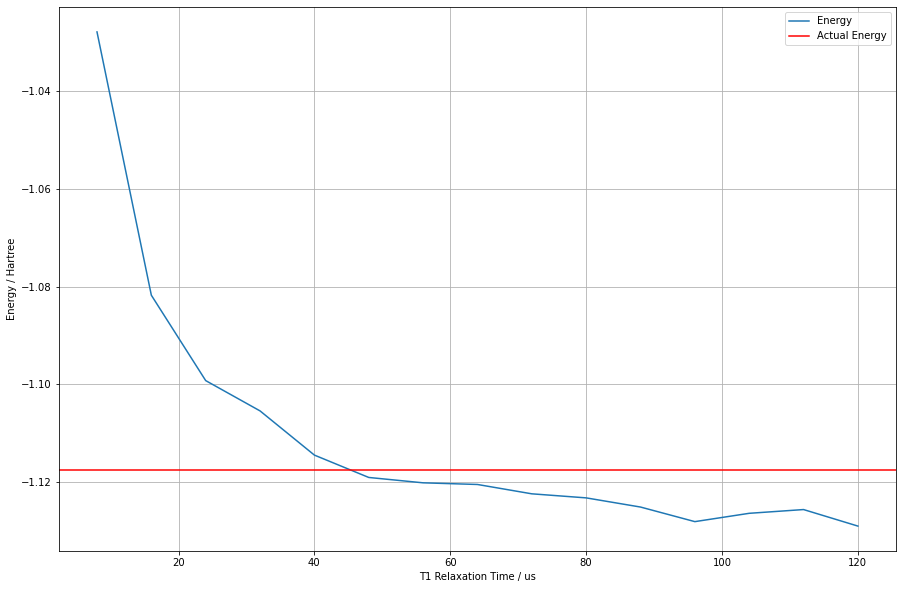

In [3]:
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies * 4, energies, label="Energy")
plt.axhline(y=-1.117506, color='r', label="Actual Energy")
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()

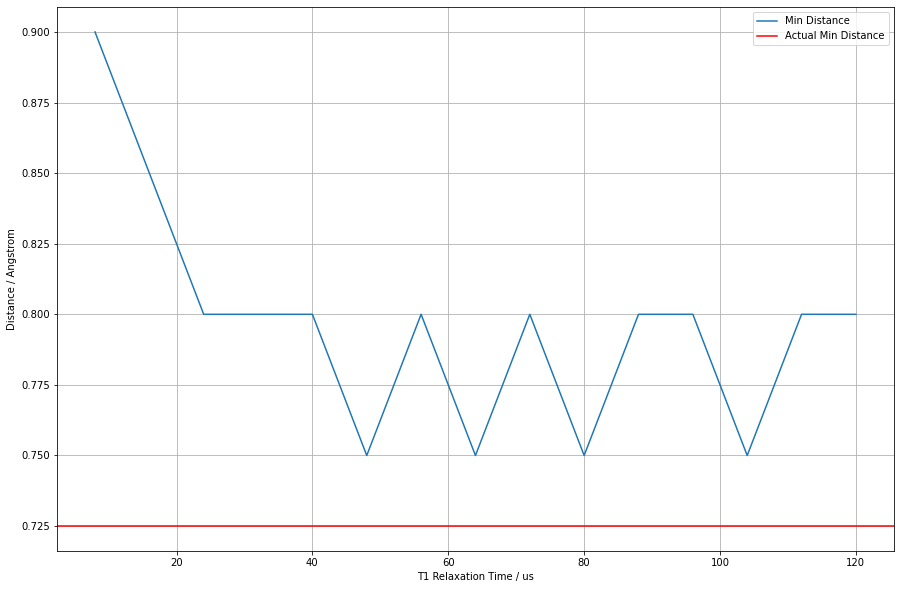

In [4]:
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies * 4, min_dist, label="Min Distance")
plt.axhline(y=0.725, color='r', label="Actual Min Distance")
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Distance / Angstrom')
plt.grid(True)
plt.legend()
plt.show()